In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
# Learning stuff
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [2]:
nyc_health = pd.read_csv(r'C:\Users\willd\Documents\Georgia Tech\CSE6424\Project\nychealth_w_desert_measures.csv')

In [3]:
nyc_health

,StateAbbr,StateDesc,CountyName,CountyFIPS,TractFIPS,TotalPopulation,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,closest_transport_nodes_y,closest_worship_nodes,closest_worship_nodes_travel_time,closest_worship_nodes_x,closest_worship_nodes_y,nodes,nodes_x,nodes_y,physical_dist,transport_dist
0,NY,New York,Kings,36047,36047009600,6126,34.5,"(29.5, 39.2)",15.1,"(14.5, 15.7)",...,40.649776,42521189.0,4.0,-74.008987,40.649776,42477077.0,-74.005783,40.646015,0.158174,0.498002
1,NY,New York,Kings,36047,36047011600,4816,28.0,"(23.5, 32.6)",16.9,"(16.2, 17.6)",...,40.634357,42486091.0,7.0,-74.010742,40.634357,42473465.0,-74.005005,40.636425,0.377913,0.535944
2,NY,New York,Kings,36047,36047046000,3729,15.0,"(12.9, 17.3)",19.0,"(18.2, 19.8)",...,40.635517,42485802.0,9.0,-73.963348,40.635517,42517167.0,-73.968407,40.631508,0.797871,0.617204
3,NY,New York,Bronx,36005,36005031400,1966,13.8,"(11.8, 15.9)",22.0,"(21.0, 22.9)",...,40.858040,470207824.0,4.0,-73.846474,40.858040,42745688.0,-73.845444,40.860939,0.679142,0.333808
4,NY,New York,Bronx,36005,36005042300,4100,26.7,"(22.7, 31.0)",16.9,"(16.3, 17.5)",...,40.878746,42739327.0,5.0,-73.872543,40.878746,42757892.0,-73.876549,40.876602,0.000000,0.412595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112,NY,New York,Queens,36081,36081113900,3322,13.9,"(11.9, 16.0)",19.7,"(18.9, 20.6)",...,40.761730,42892953.0,4.0,-73.791771,40.761730,42873728.0,-73.790245,40.763653,0.169904,0.249437
2113,NY,New York,Kings,36047,36047058000,3365,16.8,"(15.1, 18.5)",18.3,"(17.7, 18.9)",...,40.598938,42534874.0,0.0,-73.955475,40.598938,42534874.0,-73.955475,40.598938,0.286232,0.000000
2114,NY,New York,New York,36061,36061013900,9257,7.6,"( 6.4, 9.4)",17.3,"(16.5, 18.1)",...,40.767399,42435716.0,3.0,-73.982361,40.767399,42431560.0,-73.986206,40.767246,0.556792,0.324271
2115,NY,New York,Queens,36081,36081041400,4033,19.8,"(16.8, 23.0)",20.3,"(19.4, 21.2)",...,40.696037,42916014.0,5.0,-73.782730,40.696037,42900823.0,-73.781059,40.698818,0.307807,0.339795


In [4]:
nyc_health.columns

Index(['StateAbbr', 'StateDesc', 'CountyName', 'CountyFIPS', 'TractFIPS',
       'TotalPopulation', 'ACCESS2_CrudePrev', 'ACCESS2_Crude95CI',
       'ARTHRITIS_CrudePrev', 'ARTHRITIS_Crude95CI', 'BINGE_CrudePrev',
       'BINGE_Crude95CI', 'BPHIGH_CrudePrev', 'BPHIGH_Crude95CI',
       'BPMED_CrudePrev', 'BPMED_Crude95CI', 'CANCER_CrudePrev',
       'CANCER_Crude95CI', 'CASTHMA_CrudePrev', 'CASTHMA_Crude95CI',
       'CERVICAL_CrudePrev', 'CERVICAL_Crude95CI', 'CHD_CrudePrev',
       'CHD_Crude95CI', 'CHECKUP_CrudePrev', 'CHECKUP_Crude95CI',
       'CHOLSCREEN_CrudePrev', 'CHOLSCREEN_Crude95CI',
       'COLON_SCREEN_CrudePrev', 'COLON_SCREEN_Crude95CI', 'COPD_CrudePrev',
       'COPD_Crude95CI', 'COREM_CrudePrev', 'COREM_Crude95CI',
       'COREW_CrudePrev', 'COREW_Crude95CI', 'CSMOKING_CrudePrev',
       'CSMOKING_Crude95CI', 'DENTAL_CrudePrev', 'DENTAL_Crude95CI',
       'DEPRESSION_CrudePrev', 'DEPRESSION_Crude95CI', 'DIABETES_CrudePrev',
       'DIABETES_Crude95CI', 'GHLTH_CrudePre

In [5]:
# Get the features
X = nyc_health[['closest_education_nodes_travel_time', 'closest_food_nodes_travel_time', 'closest_worship_nodes_travel_time', 'physical_dist', 'transport_dist']].to_numpy()
ys = {k: nyc_health[k].to_numpy() for k in nyc_health.columns if k.endswith('_CrudePrev')}

In [6]:
remove = pd.isnull(X).any(axis=1)
xs = {}
x_trains, x_tests, y_trains, y_tests = {}, {}, {}, {}
for k, v in ys.items():
    remove1 = pd.isnull(v)
    xs[k] = X[~(remove | remove1)]
    ys[k] = v[~(remove | remove1)]
    x_train, x_test, y_train, y_test = train_test_split(xs[k], ys[k], test_size=0.2)
    x_trains[k] = x_train
    y_trains[k] = y_train
    x_tests[k] = x_test
    y_tests[k] = y_test

In [7]:
# Scale the data
for k, v in x_trains.items():
    s_scaler = StandardScaler()
    x_trains[k] = s_scaler.fit_transform(v.astype(float))
    x_tests[k] = s_scaler.transform(x_tests[k].astype(float))

In [8]:
models = {}
for k, v in x_trains.items():
# Basic dense model
    model = Sequential()
    model.add(Dense(5*8, activation='relu'))
    model.add(Dense(5*4, activation='relu'))
    model.add(Dense(5*2, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mse')
    models[k] = model

In [9]:
# Fit the model
for k, model in tqdm(models.items()):
    model.fit(x=x_trains[k], y=y_trains[k],
          validation_data=(x_tests[k], y_tests[k]),
          batch_size=128, epochs=300, verbose=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [16:25<00:00, 32.84s/it]


ACCESS2_CrudePrev
ARTHRITIS_CrudePrev
BINGE_CrudePrev
BPHIGH_CrudePrev
BPMED_CrudePrev
CANCER_CrudePrev
CASTHMA_CrudePrev
CERVICAL_CrudePrev
CHD_CrudePrev
CHECKUP_CrudePrev
CHOLSCREEN_CrudePrev
COLON_SCREEN_CrudePrev
COPD_CrudePrev
COREM_CrudePrev
COREW_CrudePrev
CSMOKING_CrudePrev
DENTAL_CrudePrev
DEPRESSION_CrudePrev
DIABETES_CrudePrev
GHLTH_CrudePrev
HIGHCHOL_CrudePrev
KIDNEY_CrudePrev
LPA_CrudePrev
MAMMOUSE_CrudePrev
MHLTH_CrudePrev


C:\Users\willd\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


OBESITY_CrudePrev
PHLTH_CrudePrev
SLEEP_CrudePrev
STROKE_CrudePrev
TEETHLOST_CrudePrev


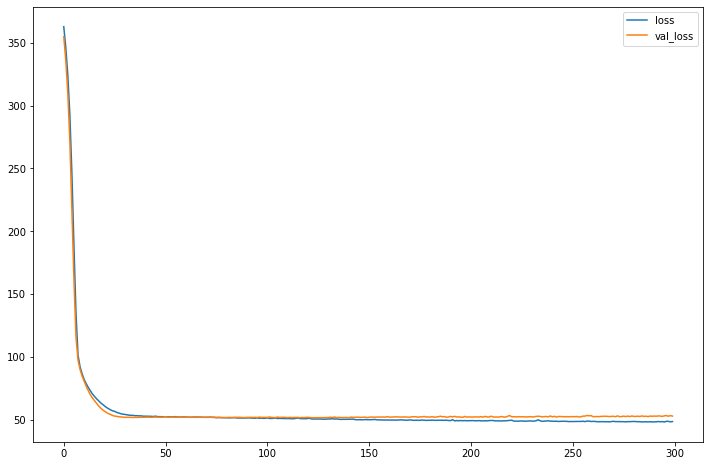

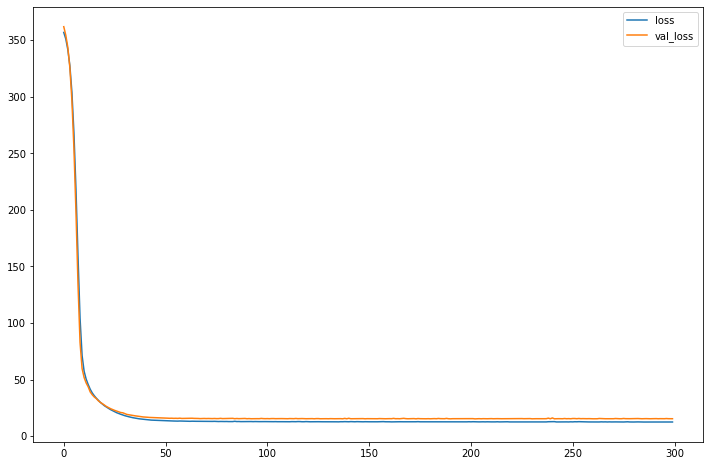

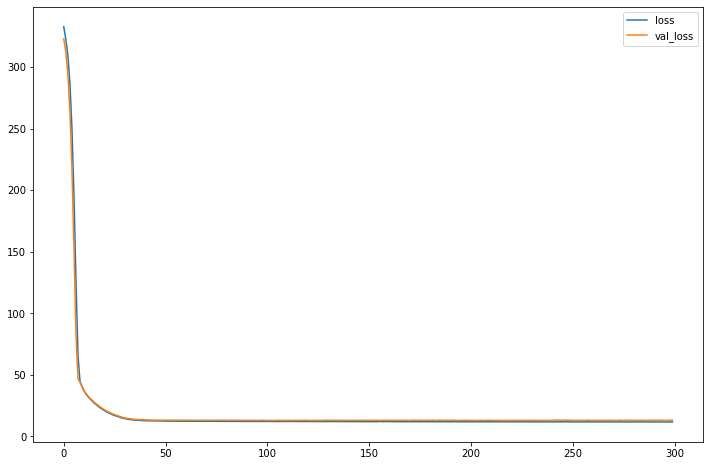

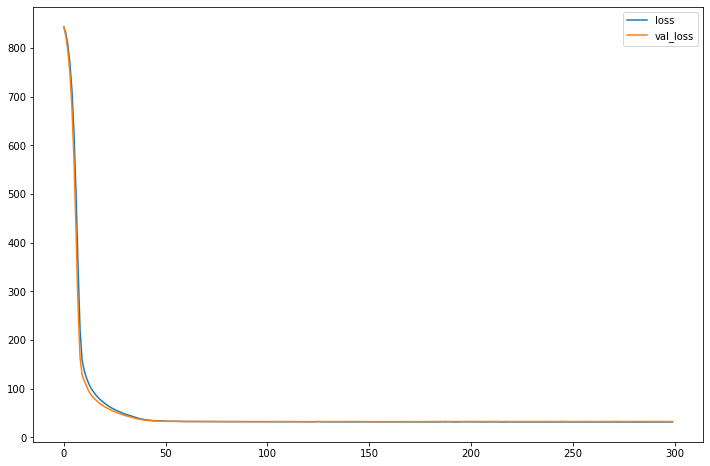

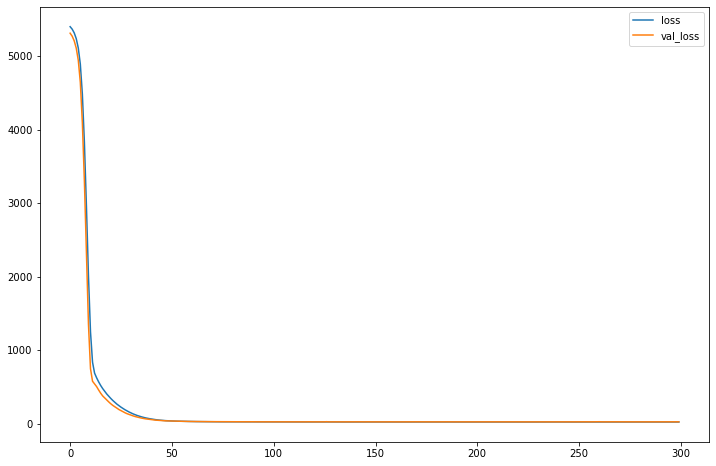

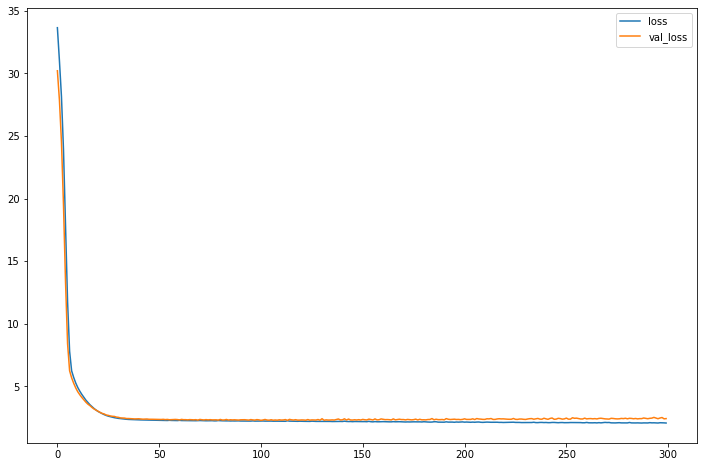

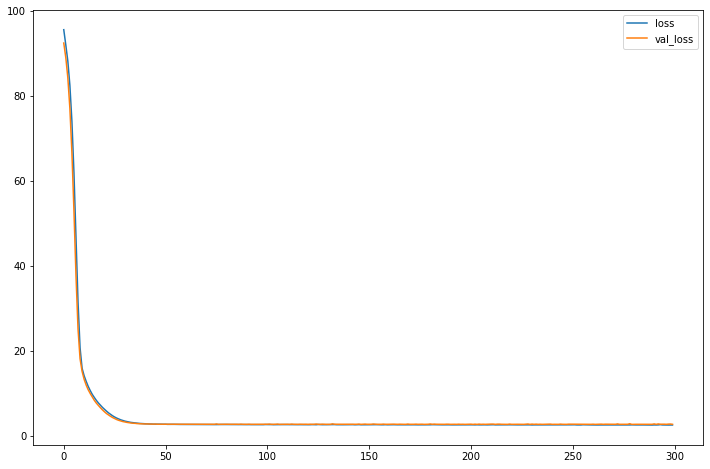

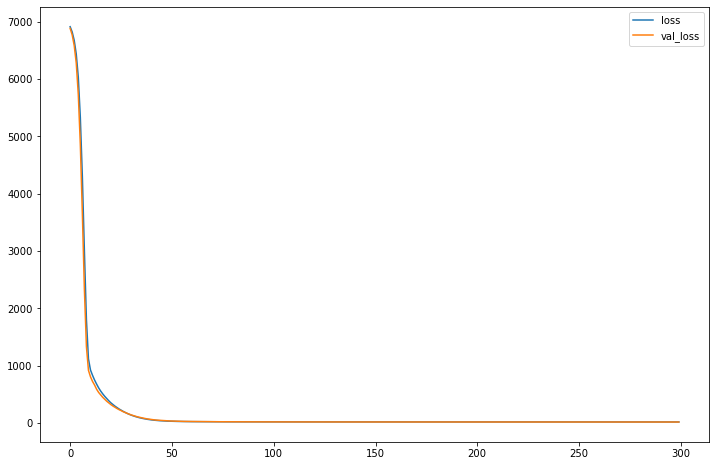

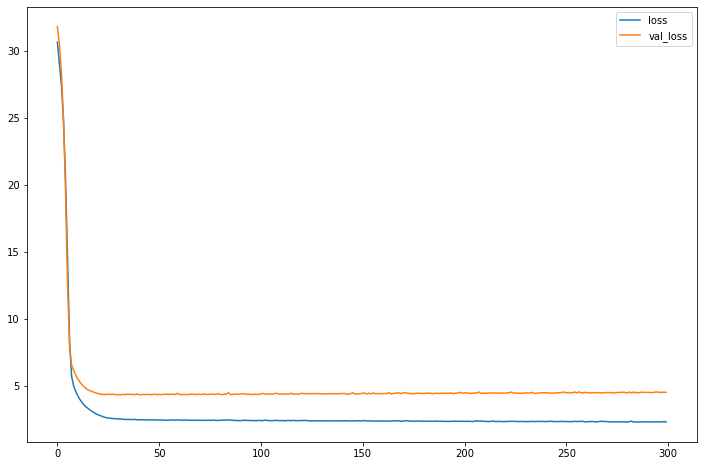

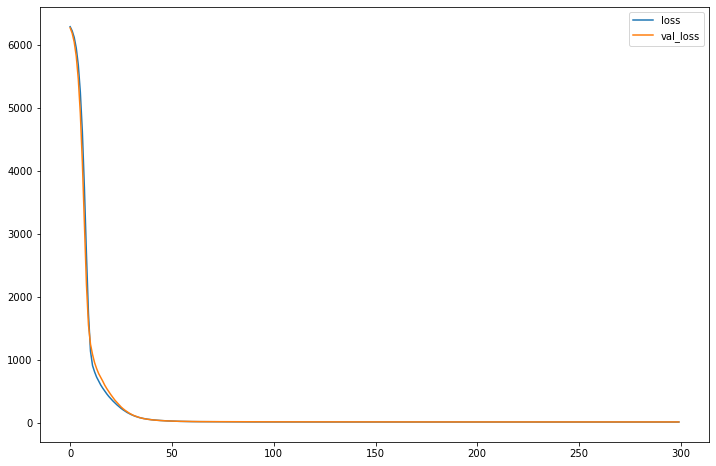

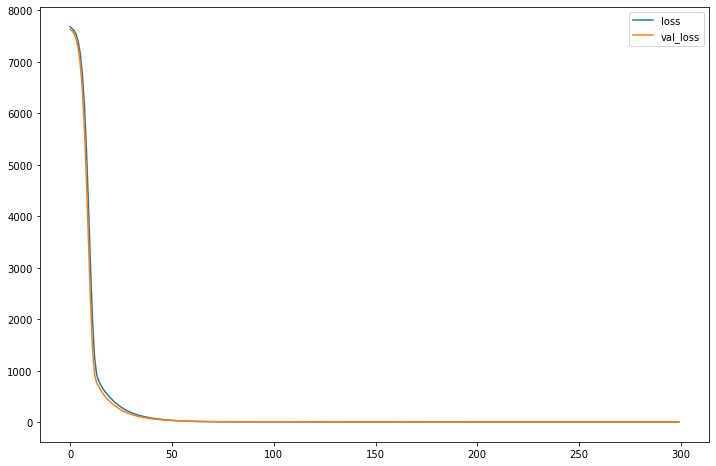

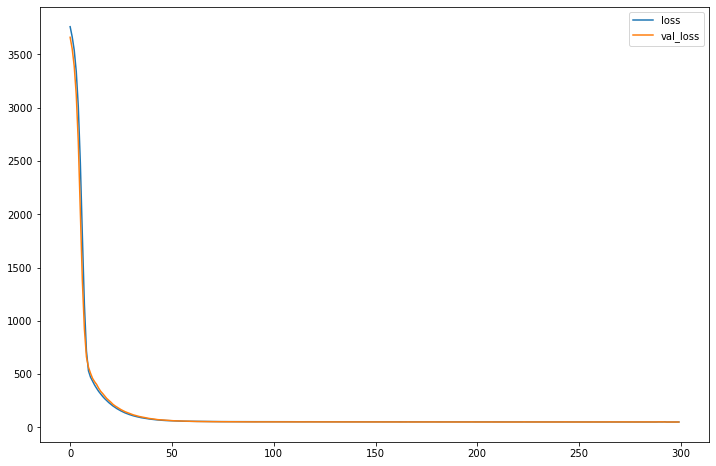

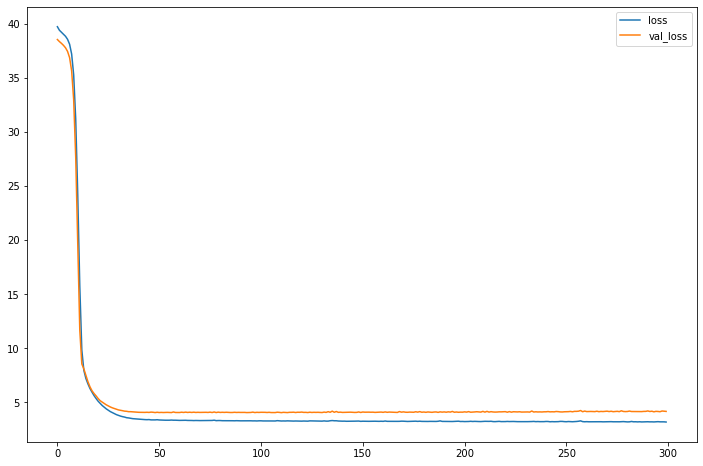

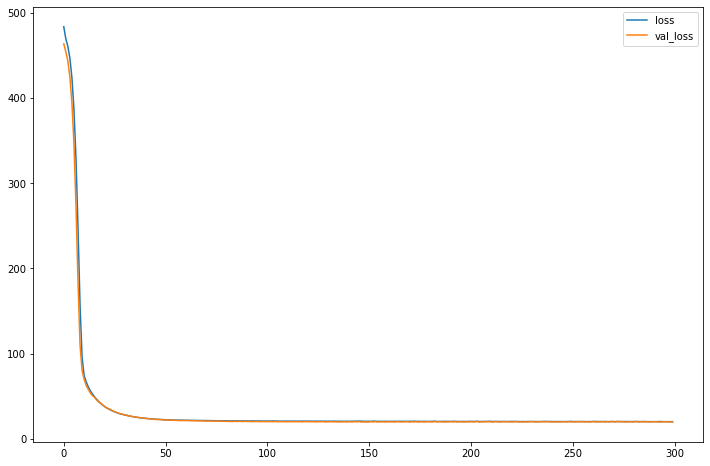

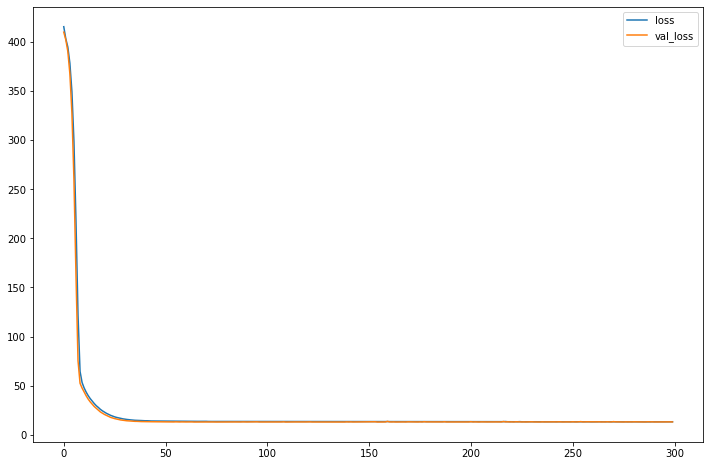

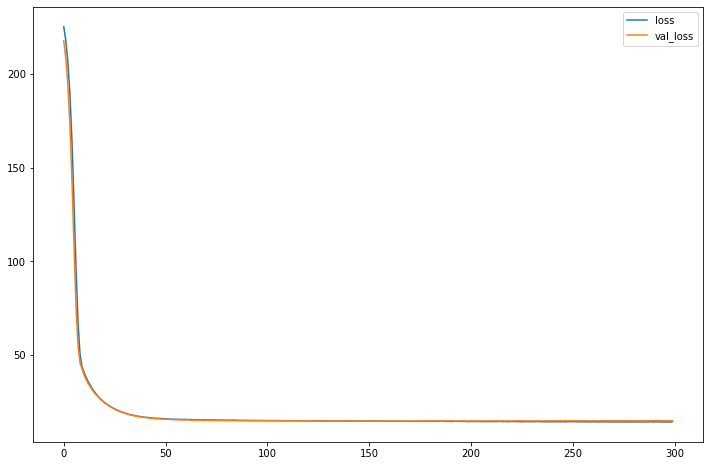

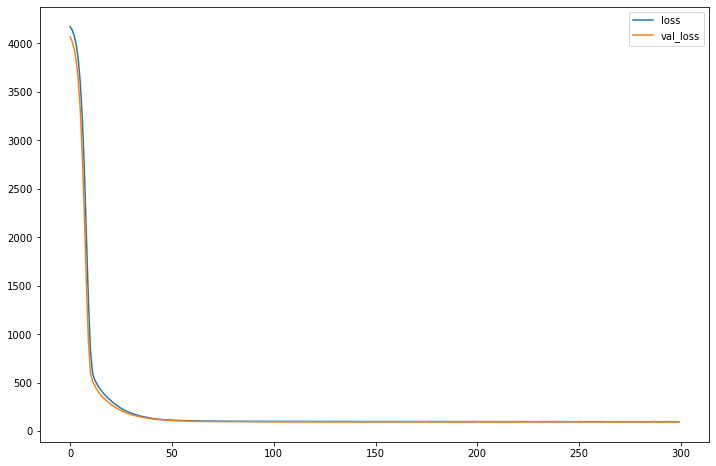

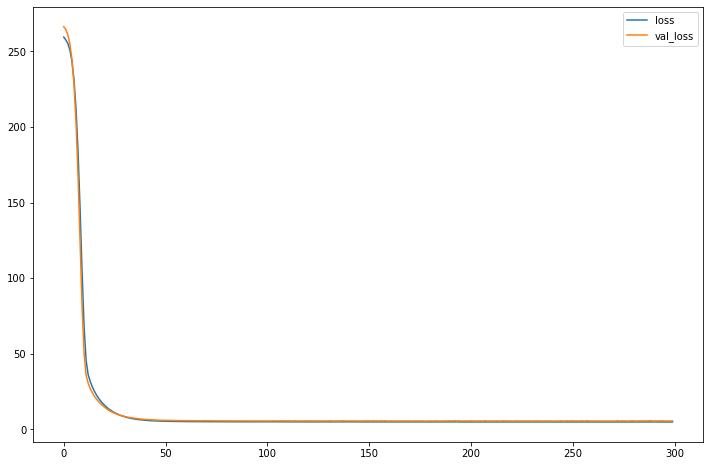

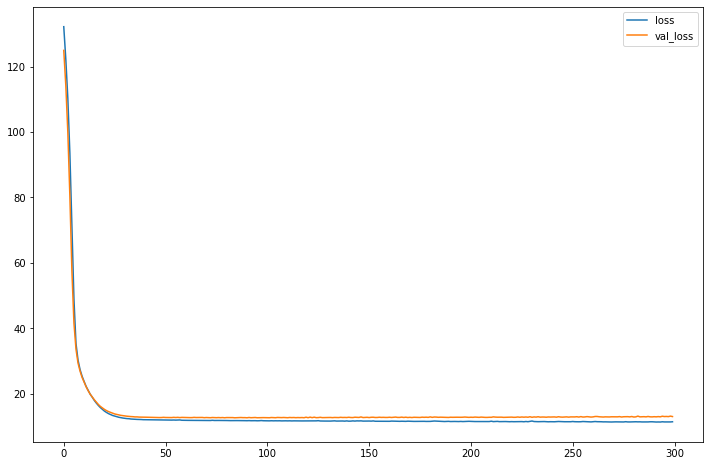

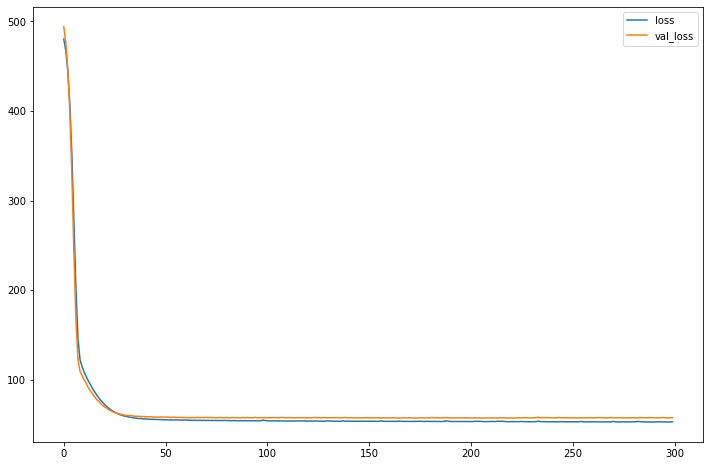

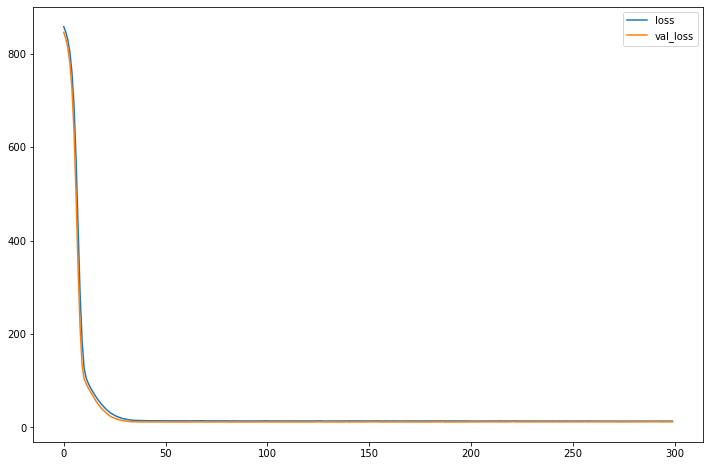

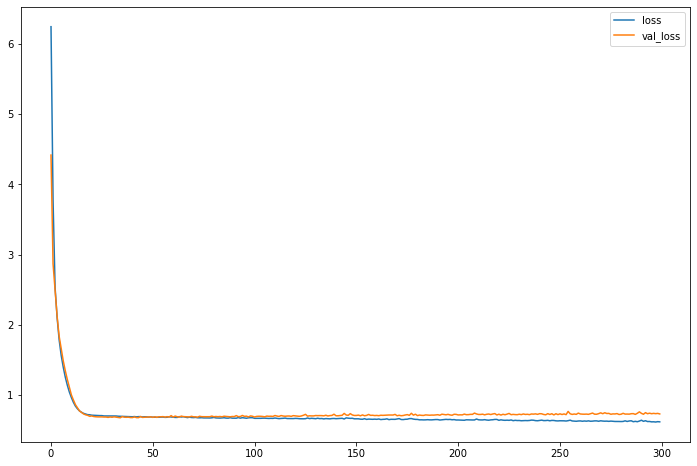

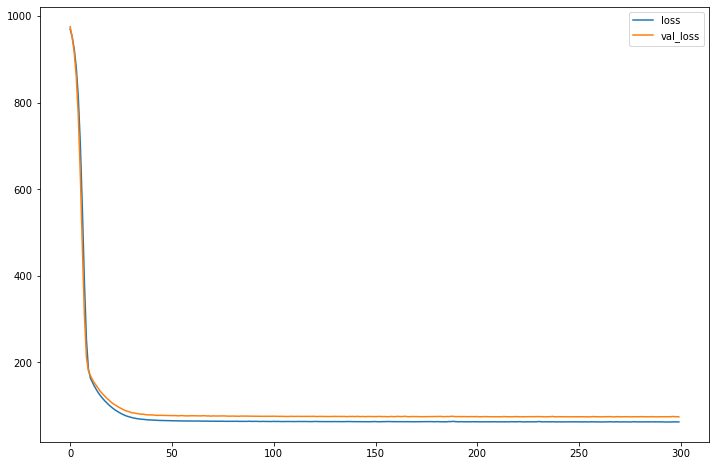

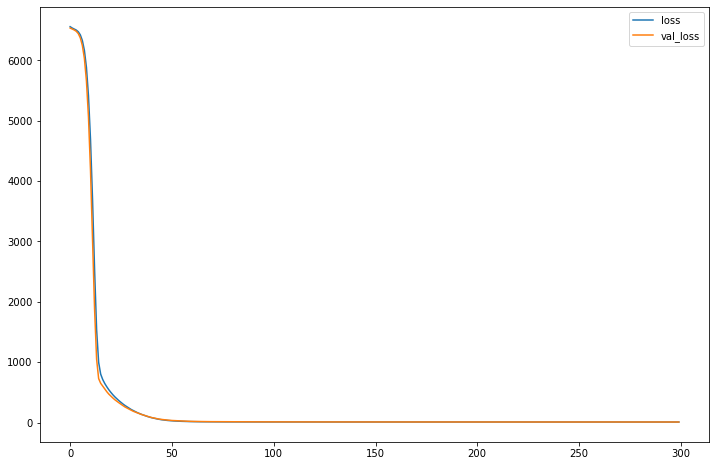

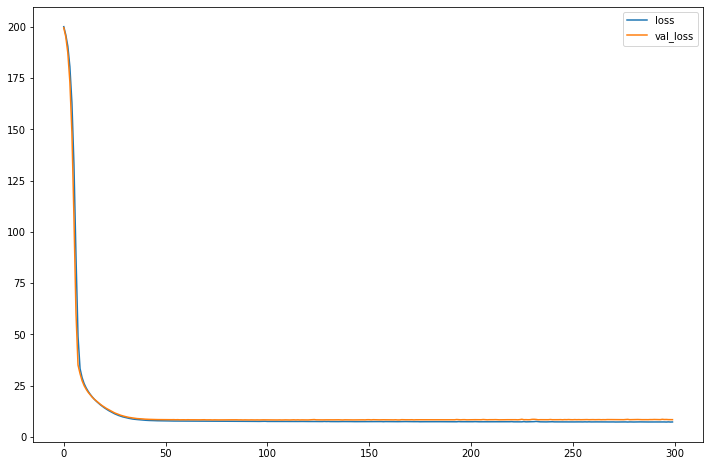

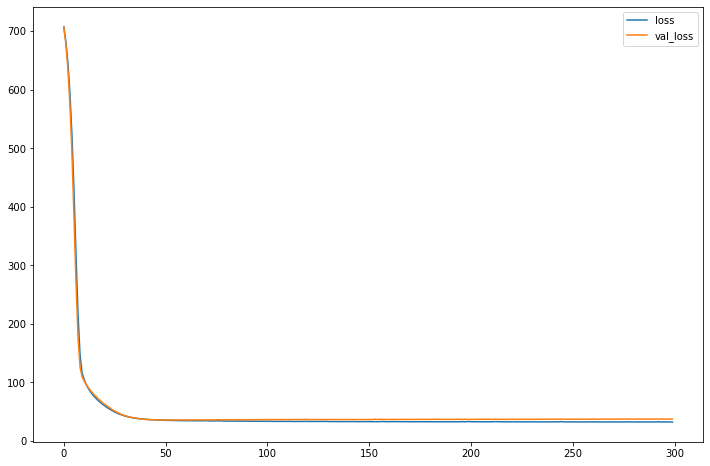

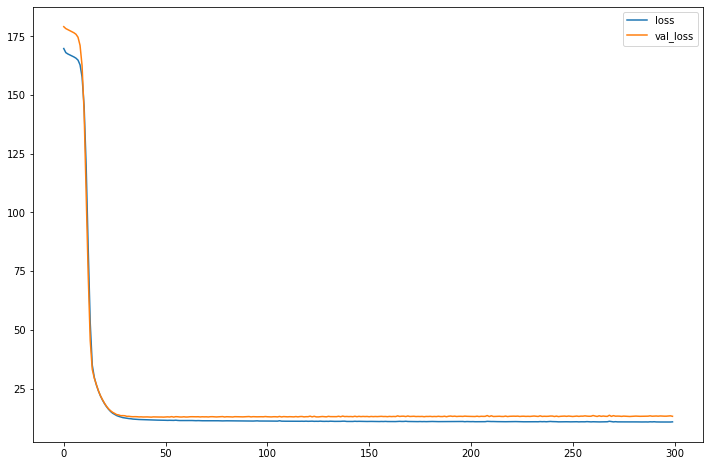

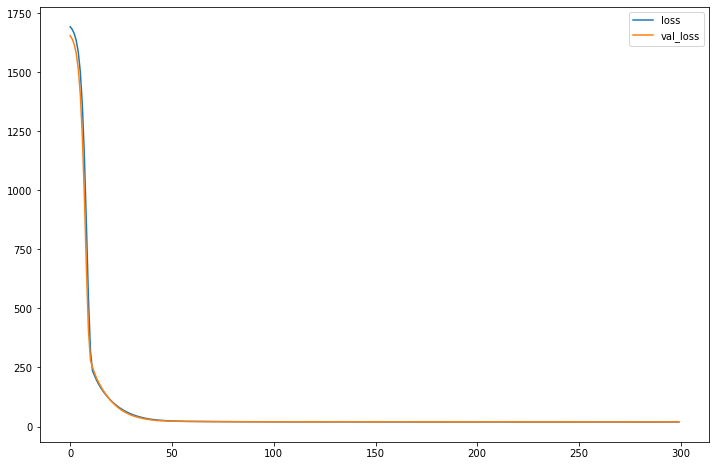

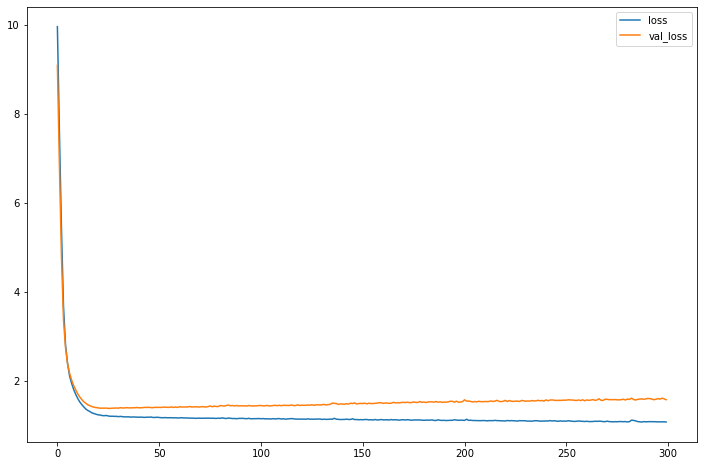

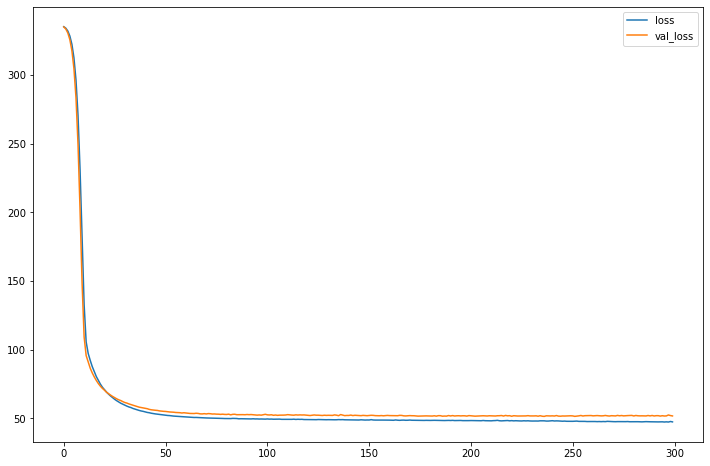

In [10]:
# Plot the training loss
for k, model in models.items():
    print(k)
    loss_df = pd.DataFrame(model.history.history)
    loss_df.plot(figsize=(12,8))

ACCESS2_CrudePrev : 0.08333873361412406


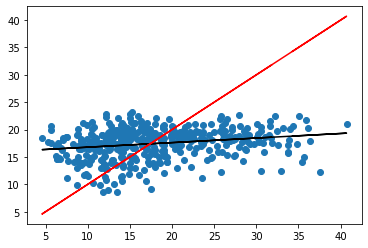

ARTHRITIS_CrudePrev : 0.10283531328011876


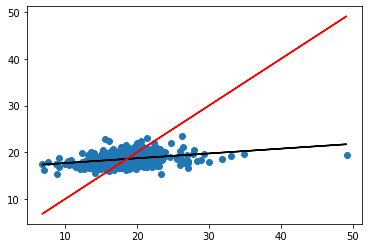

BINGE_CrudePrev : 0.08467771816802745


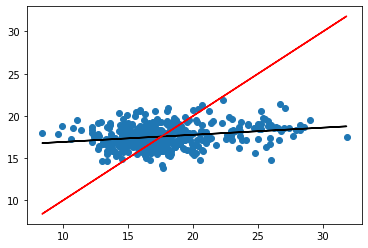

BPHIGH_CrudePrev : 0.1392257723615145


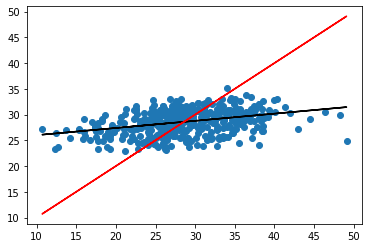

BPMED_CrudePrev : 0.08688656629250183


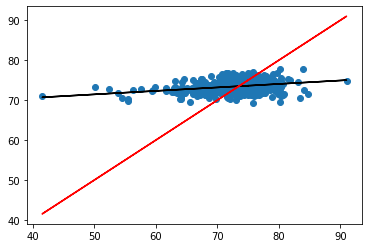

CANCER_CrudePrev : 0.06452663140655907


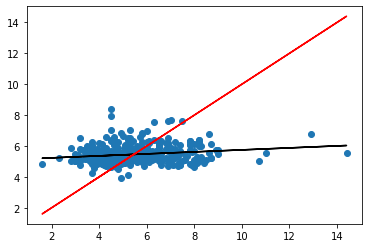

CASTHMA_CrudePrev : 0.10080567971799227


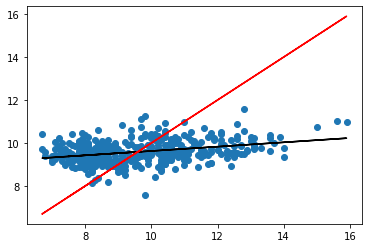

CERVICAL_CrudePrev : 0.04656170839486697


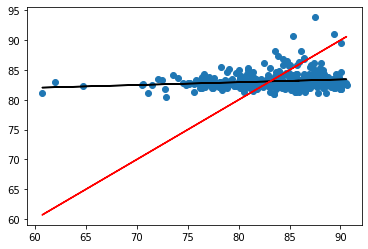

CHD_CrudePrev : 0.023359497920527206


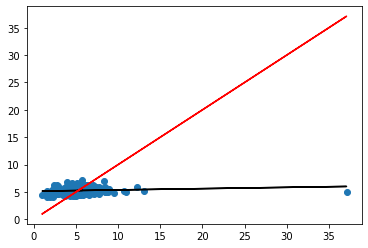

CHECKUP_CrudePrev : 0.1321976916491667


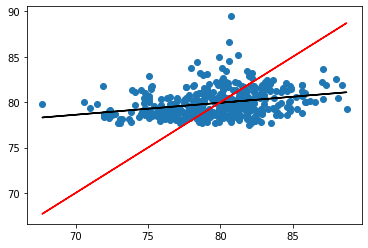

CHOLSCREEN_CrudePrev : 0.017756250758787968


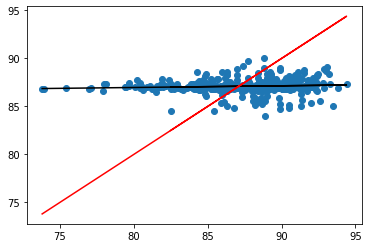

COLON_SCREEN_CrudePrev : 0.044361510757413986


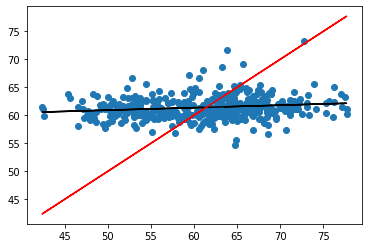

COPD_CrudePrev : 0.07946902705766767


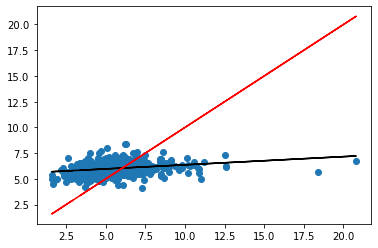

COREM_CrudePrev : 0.06943694800402221


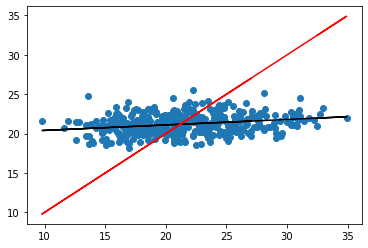

COREW_CrudePrev : 0.11316687600892365


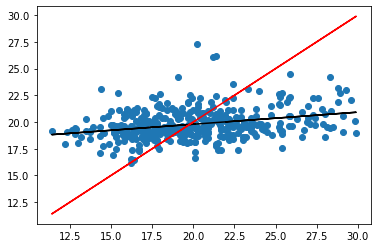

CSMOKING_CrudePrev : 0.07557774456625539


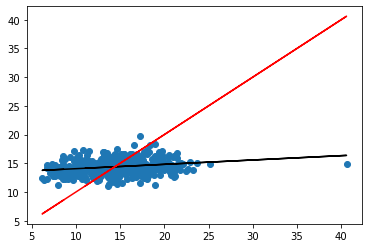

DENTAL_CrudePrev : 0.07372469378138875


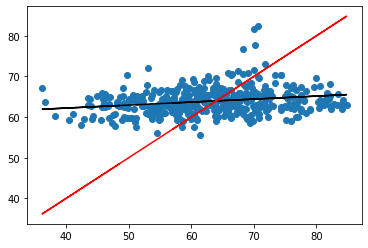

DEPRESSION_CrudePrev : 0.05701623853380083


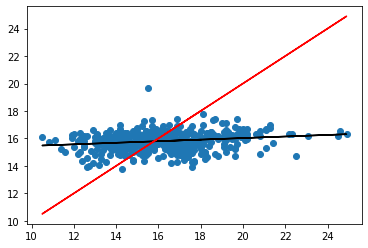

DIABETES_CrudePrev : 0.08869905673486121


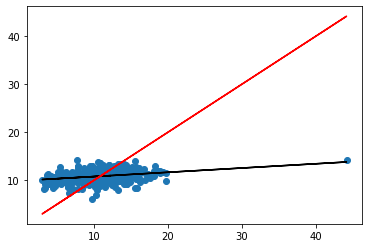

GHLTH_CrudePrev : 0.06584588567742451


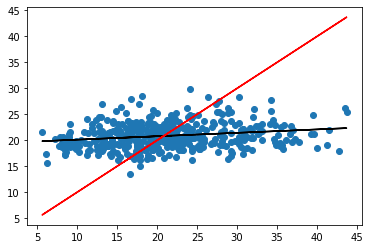

HIGHCHOL_CrudePrev : 0.04762743169454558


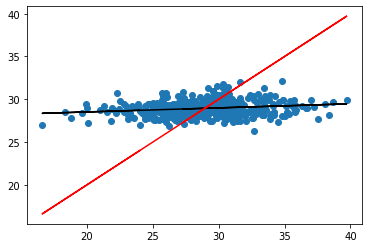

KIDNEY_CrudePrev : 0.09856997877123948


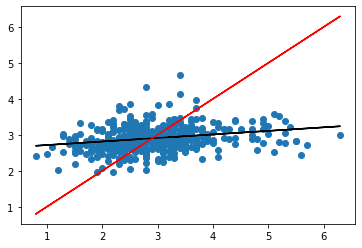

LPA_CrudePrev : 0.07932069861865465


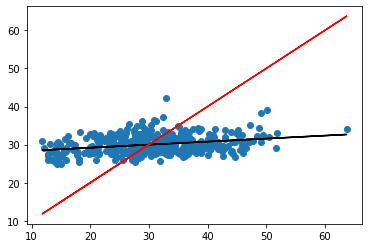

MAMMOUSE_CrudePrev : 0.030167691526764857


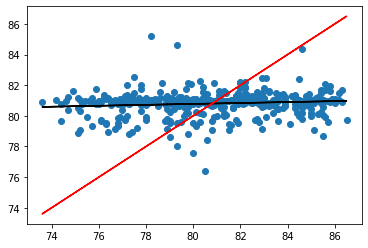

MHLTH_CrudePrev : 0.09473112521048152


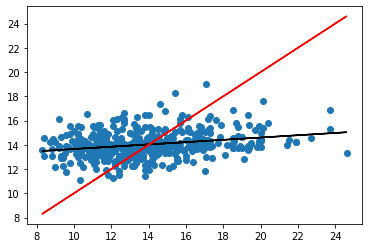

OBESITY_CrudePrev : 0.09648939615567327


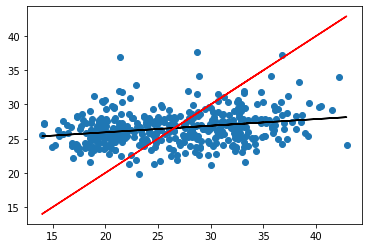

PHLTH_CrudePrev : 0.06616544873012913


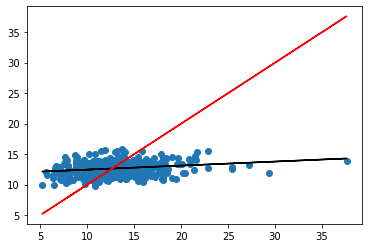

SLEEP_CrudePrev : 0.09897136836483446


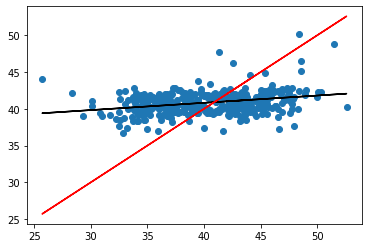

STROKE_CrudePrev : 0.03028789817067397


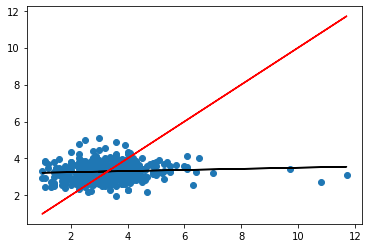

TEETHLOST_CrudePrev : 0.06047193991611522


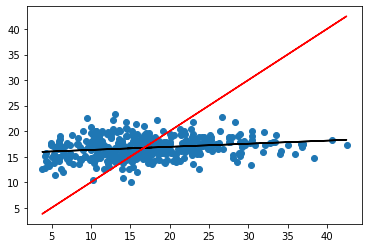

In [13]:
# Red - perfect fit; Black - actual fit
for k, model in models.items():
    y_pred = model.predict(x_tests[k])
    slope, intercept, r_value, p_value, std_err = linregress(y_tests[k], y_pred.flatten())
    print(k, ':', slope)
    plt.scatter(y_tests[k], y_pred)
    plt.plot(y_tests[k], slope*y_tests[k]+intercept, 'k')
    plt.plot(y_tests[k], y_tests[k], 'r')
    plt.show()